In [ ]:
import os
import shutil
import cv2
import torch
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.optim as optim
import tqdm
import torchvision.transforms as transforms
import random
from pathlib import Path

In [ ]:
DEVICE = torch.device('cuda')
torch.cuda.is_available()

True

In [ ]:
class FluidDataset(Dataset):
    def __init__(self, images_dir, masks_dir, image_size=(64, 64)):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.image_files = sorted(os.listdir(images_dir))
        self.mask_files = sorted(os.listdir(masks_dir))
        self.image_size = image_size

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_path = os.path.join(self.images_dir, self.image_files[idx])
        mask_path = os.path.join(self.masks_dir, self.mask_files[idx])

        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        orig_size = image.shape[:2]  # (height, width)

        #resize image and mask
        image = cv2.resize(image, self.image_size, interpolation=cv2.INTER_LINEAR)
        mask = cv2.resize(mask, self.image_size, interpolation=cv2.INTER_NEAREST)

        #normalize and convert to tensor
        image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1) / 255.0
        mask = torch.tensor(mask, dtype=torch.float32).unsqueeze(0) / 255.0
        return {"image": image, "mask": mask, "orig_size": orig_size}

In [ ]:
from torchvision.transforms import Resize

def visualize_samples(dataset, num_samples=2):
    plt.figure(figsize=(15, 5*num_samples))
    for i in range(num_samples):
        sample = dataset[i]
        image = sample['image']
        mask = sample['mask'].squeeze().numpy()
        orig_size = sample['orig_size']

        # Resize the image to the original size
        resize_transform = Resize(orig_size)
        image_resized = resize_transform(image).permute(1, 2, 0).numpy()

        # Resize the mask to the original size
        mask_resized = cv2.resize(mask, (orig_size[1], orig_size[0]), interpolation=cv2.INTER_NEAREST)

        overlayed_image = overlay_mask(image_resized, mask_resized)

        plt.subplot(num_samples, 3, 3 * i + 1)
        plt.imshow(image_resized)
        plt.title('Original Image')

        plt.subplot(num_samples, 3, 3 * i + 2)
        plt.imshow(mask_resized, cmap='gray', vmin=0, vmax=1)
        plt.title('Mask')

        plt.subplot(num_samples, 3, 3 * i + 3)
        plt.imshow(overlayed_image)
        plt.title('Overlayed Image')

    plt.show()

def overlay_mask(image, mask, alpha=0.5, color=(0, 1, 0)):
    """Overlay a mask on an image."""
    mask = (mask > 0).astype(np.uint8)
    colored_mask = np.zeros_like(image)
    colored_mask[mask == 1] = color
    overlayed_image = image * (1 - alpha) + colored_mask * alpha
    overlayed_image = np.clip(overlayed_image, 0, 1)
    return overlayed_image

def visualize_predictions(dataset, model, num_samples=10):
    """
    Visualize predictions from a model on a given dataset.

    Parameters:
    - dataset: The dataset to visualize (e.g., val_dataset).
    - model: The trained model to use for predictions.
    - num_samples: The number of samples to visualize.
    """
    model.eval()
    for i in range(num_samples):
        sample = dataset[np.random.randint(len(dataset))]

        image = sample["image"].unsqueeze(0).to(DEVICE)
        mask = sample["mask"].numpy().squeeze()
        orig_size = sample["orig_size"]

        with torch.no_grad():
            y = model(image).sigmoid().cpu().numpy().squeeze()

        binary_mask = (y > 0.5).astype(np.float32)

        # Resize the binary mask and ground truth mask to the original size
        binary_mask_resized = cv2.resize(binary_mask, (orig_size[1], orig_size[0]), interpolation=cv2.INTER_NEAREST)
        mask_resized = cv2.resize(mask, (orig_size[1], orig_size[0]), interpolation=cv2.INTER_NEAREST)

        # Resize the image to the original size
        resize_transform = Resize(orig_size)
        image_resized = resize_transform(image.squeeze().cpu()).permute(1, 2, 0).numpy()

        plt.figure(figsize=(15, 5))

        plt.subplot(131)
        plt.imshow(image_resized)
        plt.title("Original Image")

        plt.subplot(132)
        plt.imshow(mask_resized, cmap='gray', vmin=0, vmax=1)
        plt.title("Ground Truth Mask")

        plt.subplot(133)
        plt.imshow(binary_mask_resized, cmap='gray', vmin=0, vmax=1)
        plt.title("Predicted Mask (Binary)")

        plt.show()

In [ ]:
# Run one time
train_img_folder = 'segment_fluid/train/images'
train_mask_folder = 'segment_fluid/train/masks'
val_img_folder = 'segment_fluid/val/images'
val_mask_folder = 'segment_fluid/val/masks'

os.makedirs(train_img_folder)
os.makedirs(train_mask_folder)
os.makedirs(val_img_folder)
os.makedirs(val_mask_folder)

In [ ]:
# Run one time
images_folder = 'seg_dataset/images'
masks_folder = 'seg_dataset/masks'


images = sorted(os.listdir(images_folder))
masks = sorted(os.listdir(masks_folder))

pairs = list(zip(images, masks))

split_size = 0.8
random.shuffle(pairs)

split_idx = int(len(pairs) * split_size)
train_pairs = pairs[:split_idx]
val_pairs = pairs[split_idx:]

for img, mask in train_pairs:
    shutil.copy(os.path.join(images_folder, img), os.path.join(train_img_folder, img))
    shutil.copy(os.path.join(masks_folder, mask), os.path.join(train_mask_folder, mask))

for img, mask in val_pairs:
    shutil.copy(os.path.join(images_folder, img), os.path.join(val_img_folder, img))
    shutil.copy(os.path.join(masks_folder, mask), os.path.join(val_mask_folder, mask))


In [ ]:
train_dataset = FluidDataset('segment_fluid/train/images',
                             'segment_fluid/train/masks')
validation_dataset = FluidDataset('segment_fluid/val/images',
                                  'segment_fluid/val/masks')

In [ ]:
class FluidAugmentedDataset(FluidDataset):
    def __init__(self, images_dir, masks_dir, image_transform=None, mask_transform=None, image_size=(64, 64)):
        super().__init__(images_dir, masks_dir, image_size=image_size)
        self.image_transform = image_transform
        self.mask_transform = mask_transform

    def __getitem__(self, idx):
        image_path = os.path.join(self.images_dir, self.image_files[idx])
        mask_path = os.path.join(self.masks_dir, self.mask_files[idx])

        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        orig_size = image.shape[:2]

        image = cv2.resize(image, self.image_size, interpolation=cv2.INTER_LINEAR)
        mask = cv2.resize(mask, self.image_size, interpolation=cv2.INTER_LINEAR)

        image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1) / 255
        mask = torch.tensor(mask, dtype=torch.float32).unsqueeze(0) / 255

        if self.image_transform and self.mask_transform:
            seed = random.randint(0, 2**32 - 1)
            random.seed(seed)
            torch.manual_seed(seed)
            image = self.image_transform(image)
            random.seed(seed)
            torch.manual_seed(seed)
            mask = self.mask_transform(mask)


        return {"image": image, "mask": mask, "orig_size": orig_size}

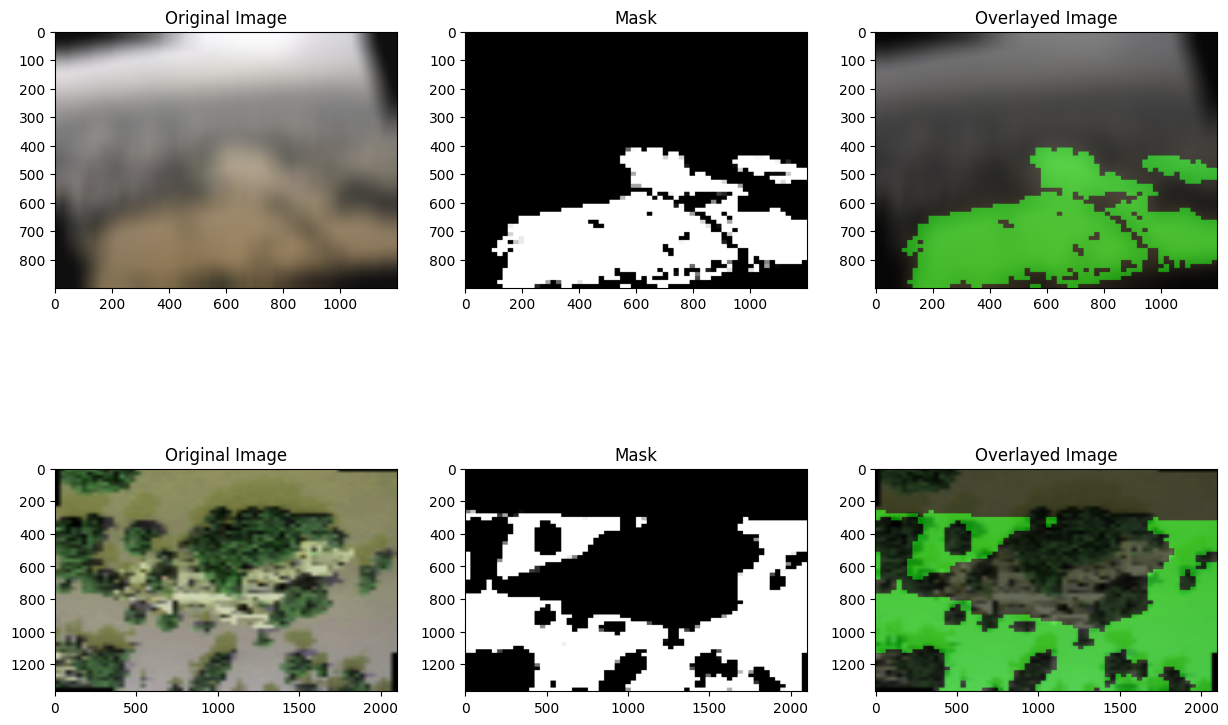

In [ ]:
image_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
])

mask_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(30),
])

train_augmented_dataset = FluidAugmentedDataset('segment_fluid/train/images',
                                                   'segment_fluid/train/masks',
                                                   image_transform=image_transform,
                                                   mask_transform=mask_transform)


visualize_samples(train_augmented_dataset, num_samples=2)

In [ ]:
trained_models_info = []
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
train_augmented_loader = DataLoader(train_augmented_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(validation_dataset, batch_size=1, shuffle=False)

In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, device=DEVICE):
    """
    Train a given model using the provided data loaders, loss function, and optimizer.

    Parameters:
    - model: The model to be trained.
    - train_loader: DataLoader for the training dataset.
    - val_loader: DataLoader for the validation dataset.
    - criterion: The loss function.
    - optimizer: The optimizer.
    - num_epochs: Number of training epochs (default is 10).
    - device: The device to use for training (default is 'cuda' if available).

    Returns:
    - model: The trained model.
    """
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for batch in tqdm.tqdm(train_loader):
            images, masks = batch["image"].to(device), batch["mask"].to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}")

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch in tqdm.tqdm(val_loader):
                images, masks = batch["image"].to(device), batch["mask"].to(device)
                outputs = model(images)
                loss = criterion(outputs, masks)
                val_loss += loss.item()
        print(f"Validation Loss: {val_loss/len(val_loader)}")

    return model


In [ ]:
import torch.nn.functional as F

class FCN(nn.Module):
    def __init__(self):
        super(FCN, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.middle = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.decoder = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2, padding=0),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1)
        )

    def forward(self, x):
        x1 = self.encoder(x)
        x2 = self.middle(x1)
        x3 = self.decoder(x2)
        return x3

simple dataset

In [ ]:
model_fcn = FCN().to(DEVICE)
criterion_fcn = nn.BCEWithLogitsLoss()
optimizer_fcn = optim.Adam(model_fcn.parameters(), lr=0.001)

model_fcn = train_model(model_fcn, train_loader, val_loader, criterion_fcn, optimizer_fcn, num_epochs=10, device=DEVICE)

trained_models_info.append((model_fcn, "train_dataset", criterion_fcn, optimizer_fcn, 0.001, 10))

torch.save(model_fcn.state_dict(), "segmentation_model_fcn.pth")

visualize_predictions(validation_dataset, model_fcn, num_samples=2)


In [ ]:
model_fcn_aug = FCN().to(DEVICE)
criterion_fcn =  nn.BCEWithLogitsLoss()
optimizer_fcn = optim.Adam(model_fcn_aug.parameters(), lr=0.001)

model_fcn_aug = train_model(model_fcn_aug, train_augmented_loader, val_loader, criterion_fcn, optimizer_fcn, num_epochs=10, device=DEVICE)

trained_models_info.append((model_fcn_aug, "train_augmented_dataset", criterion_fcn, optimizer_fcn, 0.001, 10))

torch.save(model_fcn_aug.state_dict(), "segmentation_model_fcn_aug.pth")

visualize_predictions(validation_dataset, model_fcn_aug, num_samples=2)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import tqdm

class SegNet(nn.Module):
    def __init__(self, n_classes=1):
        super(SegNet, self).__init__()
        self.encoder1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)

        self.encoder2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)

        self.decoder1 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.unpool1 = nn.MaxUnpool2d(kernel_size=2, stride=2)

        self.decoder2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, n_classes, kernel_size=3, padding=1)
        )
        self.unpool2 = nn.MaxUnpool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.encoder1(x)
        size1 = x.size()
        x, indices1 = self.pool1(x)

        x = self.encoder2(x)
        size2 = x.size()
        x, indices2 = self.pool2(x)

        x = self.unpool1(x, indices2, output_size=size2)
        x = self.decoder1(x)

        x = self.unpool2(x, indices1, output_size=size1)
        x = self.decoder2(x)

        return x


In [ ]:
# simple
model_segnet = SegNet().to(DEVICE)
criterion_segnet = nn.BCEWithLogitsLoss()
optimizer_segnet = optim.Adam(model_segnet.parameters(), lr=0.001)

model_segnet = train_model(model_segnet, train_loader, val_loader, criterion_segnet, optimizer_segnet, num_epochs=10, device=DEVICE)
trained_models_info.append((model_segnet, "train_dataset", criterion_segnet, optimizer_segnet, 0.001, 10))

torch.save(model_segnet.state_dict(), "segmentation_model_segnet.pth")

visualize_predictions(validation_dataset, model_segnet, num_samples=2)



In [ ]:
# augmented
model_segnet_aug = SegNet().to(DEVICE)
criterion_segnet = nn.BCEWithLogitsLoss()
optimizer_segnet_aug = optim.Adam(model_segnet_aug.parameters(), lr=0.001)

model_segnet_aug = train_model(model_segnet_aug, train_augmented_loader, val_loader, criterion_segnet, optimizer_segnet_aug, num_epochs=10, device=DEVICE)
trained_models_info.append((model_segnet_aug, "train_augmented_dataset", criterion_segnet, optimizer_segnet, 0.001, 10))

torch.save(model_segnet_aug.state_dict(), "segmentation_model_segnet_aug.pth")

visualize_predictions(validation_dataset, model_segnet_aug, num_samples=2)



In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        """
        Initialize the U-Net model.

        Parameters:
        - in_channels: Number of input channels (e.g., 3 for RGB images).
        - out_channels: Number of output channels (e.g., 1 for binary segmentation).
        """
        super(UNet, self).__init__()
        # Define encoder blocks
        # Define center block
        # Define decoder blocks
        # Define final layer
        filter_block = 64
        self.encoder1 = self.conv_block(in_channels, filter_block)
        self.encoder2 = self.conv_block(filter_block, filter_block * 2)
        self.encoder3 = self.conv_block(filter_block * 2, filter_block * 4)
        self.encoder4 = self.conv_block(filter_block * 4, filter_block * 8)

        self.center = self.conv_block(filter_block * 8, filter_block * 16)

        self.decoder4 = self.conv_block(filter_block * 16 + filter_block * 8, filter_block * 8)
        self.decoder3 = self.conv_block(filter_block * 8 + filter_block * 4, filter_block * 4)
        self.decoder2 = self.conv_block(filter_block * 4 + filter_block * 2, filter_block * 2)
        self.decoder1 = self.conv_block(filter_block * 2 + filter_block, filter_block)

        self.final = nn.Conv2d(filter_block, out_channels, kernel_size=1)



    def conv_block(self, in_channels, out_channels):
        """
        Create a convolutional block with two convolutional layers and ReLU activations.

        Parameters:
        - in_channels: Number of input channels.
        - out_channels: Number of output channels.
        """
        return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
        )

    def forward(self, x):
        """
        Forward pass of the U-Net model.

        Parameters:
        - x: Input tensor.

        Returns:
        - Output tensor after passing through the U-Net.
        """
        # Encoder path
        # Center block
        # Decoder path with skip connections
        # Final layer
        encoder1 = self.encoder1(x)
        encoder2 = self.encoder2(F.max_pool2d(encoder1, 2))
        encoder3 = self.encoder3(F.max_pool2d(encoder2, 2))
        encoder4 = self.encoder4(F.max_pool2d(encoder3, 2))

        center = self.center(F.max_pool2d(encoder4, 2))

        decoder4 = self.decoder4(torch.cat([F.interpolate(center, scale_factor=2, mode='bilinear', align_corners=True), encoder4], dim=1))
        decoder3 = self.decoder3(torch.cat([F.interpolate(decoder4, scale_factor=2, mode='bilinear', align_corners=True), encoder3], dim=1))
        decoder2 = self.decoder2(torch.cat([F.interpolate(decoder3, scale_factor=2, mode='bilinear', align_corners=True), encoder2], dim=1))
        decoder1 = self.decoder1(torch.cat([F.interpolate(decoder2, scale_factor=2, mode='bilinear', align_corners=True), encoder1], dim=1))

        return self.final(decoder1)



In [ ]:
trained_models_info = []
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
train_augmented_loader = DataLoader(train_augmented_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(validation_dataset, batch_size=1, shuffle=False)

In [ ]:
total_steps = len(train_loader)
losses = []
steps = []

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, device=DEVICE):
    """
    Train a given model using the provided data loaders, loss function, and optimizer.

    Parameters:
    - model: The model to be trained.
    - train_loader: DataLoader for the training dataset.
    - val_loader: DataLoader for the validation dataset.
    - criterion: The loss function.
    - optimizer: The optimizer.
    - num_epochs: Number of training epochs (default is 10).
    - device: The device to use for training (default is 'cuda' if available).

    Returns:
    - model: The trained model.
    """
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for batch in tqdm.tqdm(train_loader):
            images, masks = batch["image"].to(device), batch["mask"].to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}")

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch in tqdm.tqdm(val_loader):
                images, masks = batch["image"].to(device), batch["mask"].to(device)
                outputs = model(images)
                loss = criterion(outputs, masks)
                val_loss += loss.item()
        print(f"Validation Loss: {val_loss/len(val_loader)}")
        losses.append(val_loss/len(val_loader))
        steps.append(epoch + 1)

    return model


In [ ]:
len(train_dataset) + len(validation_dataset)

289

In [ ]:
model_unet = UNet().to(DEVICE)
criterion_unet = nn.BCEWithLogitsLoss()
optimizer_unet = optim.Adam(model_unet.parameters(), lr=0.001)

model_unet = train_model(model_unet, train_loader, val_loader, criterion_unet, optimizer_unet, num_epochs=35, device=DEVICE)
trained_models_info.append((model_unet, "train_dataset", criterion_unet, optimizer_unet, 0.001, 10))

torch.save(model_unet.state_dict(), "segmentation_model_unet.pth")

100%|██████████| 15/15 [00:10<00:00,  1.41it/s]


Epoch 1/35, Loss: 0.5055196543534597


100%|██████████| 58/58 [00:02<00:00, 23.93it/s]


Validation Loss: 1.3501567748086205


100%|██████████| 15/15 [00:10<00:00,  1.41it/s]


Epoch 2/35, Loss: 0.39373262921969093


100%|██████████| 58/58 [00:02<00:00, 22.88it/s]


Validation Loss: 0.5965279577107265


100%|██████████| 15/15 [00:11<00:00,  1.30it/s]


Epoch 3/35, Loss: 0.37172444264094034


100%|██████████| 58/58 [00:04<00:00, 13.98it/s]


Validation Loss: 0.46265159033495806


100%|██████████| 15/15 [00:26<00:00,  1.77s/it]


Epoch 4/35, Loss: 0.3454626778761546


100%|██████████| 58/58 [00:02<00:00, 21.93it/s]


Validation Loss: 0.3971525613090088


100%|██████████| 15/15 [00:08<00:00,  1.68it/s]


Epoch 5/35, Loss: 0.3551759878794352


100%|██████████| 58/58 [00:02<00:00, 26.68it/s]


Validation Loss: 0.38183285527188204


100%|██████████| 15/15 [00:08<00:00,  1.68it/s]


Epoch 6/35, Loss: 0.33251542448997495


100%|██████████| 58/58 [00:02<00:00, 25.33it/s]


Validation Loss: 0.5168695243011261


100%|██████████| 15/15 [00:09<00:00,  1.57it/s]


Epoch 7/35, Loss: 0.34300321340560913


100%|██████████| 58/58 [00:02<00:00, 23.55it/s]


Validation Loss: 0.5414404808704195


100%|██████████| 15/15 [00:10<00:00,  1.49it/s]


Epoch 8/35, Loss: 0.3322487374146779


100%|██████████| 58/58 [00:02<00:00, 23.66it/s]


Validation Loss: 0.4033078555146168


100%|██████████| 15/15 [00:09<00:00,  1.65it/s]


Epoch 9/35, Loss: 0.3396894852320353


100%|██████████| 58/58 [00:02<00:00, 25.52it/s]


Validation Loss: 0.3820595116964702


100%|██████████| 15/15 [00:18<00:00,  1.20s/it]


Epoch 10/35, Loss: 0.33397692143917085


100%|██████████| 58/58 [00:02<00:00, 26.47it/s]


Validation Loss: 0.6033176607612906


100%|██████████| 15/15 [00:08<00:00,  1.75it/s]


Epoch 11/35, Loss: 0.31918936769167583


100%|██████████| 58/58 [00:02<00:00, 25.96it/s]


Validation Loss: 0.39915017398266955


100%|██████████| 15/15 [00:08<00:00,  1.77it/s]


Epoch 12/35, Loss: 0.3157718946536382


100%|██████████| 58/58 [00:02<00:00, 26.45it/s]


Validation Loss: 0.3429006376656993


100%|██████████| 15/15 [00:08<00:00,  1.76it/s]


Epoch 13/35, Loss: 0.31066731611887616


100%|██████████| 58/58 [00:02<00:00, 26.41it/s]


Validation Loss: 0.3799402454289897


100%|██████████| 15/15 [00:08<00:00,  1.76it/s]


Epoch 14/35, Loss: 0.30521211326122283


100%|██████████| 58/58 [00:02<00:00, 26.62it/s]


Validation Loss: 0.5313052470827925


100%|██████████| 15/15 [00:08<00:00,  1.76it/s]


Epoch 15/35, Loss: 0.3275273104508718


100%|██████████| 58/58 [00:02<00:00, 26.06it/s]


Validation Loss: 0.4305117267729907


100%|██████████| 15/15 [00:08<00:00,  1.77it/s]


Epoch 16/35, Loss: 0.303591243426005


100%|██████████| 58/58 [00:02<00:00, 26.26it/s]


Validation Loss: 0.5732007824398321


100%|██████████| 15/15 [00:08<00:00,  1.75it/s]


Epoch 17/35, Loss: 0.3012492169936498


100%|██████████| 58/58 [00:02<00:00, 26.39it/s]


Validation Loss: 0.36458653429972715


100%|██████████| 15/15 [00:08<00:00,  1.77it/s]


Epoch 18/35, Loss: 0.3103563964366913


100%|██████████| 58/58 [00:02<00:00, 25.90it/s]


Validation Loss: 0.3595700190755828


100%|██████████| 15/15 [00:08<00:00,  1.75it/s]


Epoch 19/35, Loss: 0.2888183077176412


100%|██████████| 58/58 [00:02<00:00, 26.69it/s]


Validation Loss: 0.3187214242744035


100%|██████████| 15/15 [00:08<00:00,  1.75it/s]


Epoch 20/35, Loss: 0.2796547174453735


100%|██████████| 58/58 [00:02<00:00, 26.16it/s]


Validation Loss: 0.32542323398179024


100%|██████████| 15/15 [00:08<00:00,  1.75it/s]


Epoch 21/35, Loss: 0.29277373949686686


100%|██████████| 58/58 [00:02<00:00, 26.91it/s]


Validation Loss: 0.3248285346760832


100%|██████████| 15/15 [00:08<00:00,  1.76it/s]


Epoch 22/35, Loss: 0.2948563357194265


100%|██████████| 58/58 [00:02<00:00, 26.30it/s]


Validation Loss: 0.6474522454985256


100%|██████████| 15/15 [00:08<00:00,  1.76it/s]


Epoch 23/35, Loss: 0.30299248894055686


100%|██████████| 58/58 [00:02<00:00, 26.68it/s]


Validation Loss: 0.46159906582585697


100%|██████████| 15/15 [00:08<00:00,  1.75it/s]


Epoch 24/35, Loss: 0.2848941604296366


100%|██████████| 58/58 [00:02<00:00, 26.38it/s]


Validation Loss: 0.3223041569621399


100%|██████████| 15/15 [00:08<00:00,  1.76it/s]


Epoch 25/35, Loss: 0.28207597335179646


100%|██████████| 58/58 [00:02<00:00, 26.79it/s]


Validation Loss: 0.41649393801545276


100%|██████████| 15/15 [00:08<00:00,  1.75it/s]


Epoch 26/35, Loss: 0.27950137058893837


100%|██████████| 58/58 [00:02<00:00, 26.27it/s]


Validation Loss: 0.3128770258406113


100%|██████████| 15/15 [00:08<00:00,  1.78it/s]


Epoch 27/35, Loss: 0.27980324923992156


100%|██████████| 58/58 [00:02<00:00, 26.33it/s]


Validation Loss: 0.3271242084688154


100%|██████████| 15/15 [00:08<00:00,  1.76it/s]


Epoch 28/35, Loss: 0.2703821321328481


100%|██████████| 58/58 [00:02<00:00, 26.53it/s]


Validation Loss: 0.5567816231271316


100%|██████████| 15/15 [00:08<00:00,  1.76it/s]


Epoch 29/35, Loss: 0.27156597673892974


100%|██████████| 58/58 [00:02<00:00, 26.23it/s]


Validation Loss: 0.30615333660409366


100%|██████████| 15/15 [00:08<00:00,  1.74it/s]


Epoch 30/35, Loss: 0.25407258967558544


100%|██████████| 58/58 [00:02<00:00, 26.52it/s]


Validation Loss: 0.30912753605637056


100%|██████████| 15/15 [00:08<00:00,  1.74it/s]


Epoch 31/35, Loss: 0.2553201258182526


100%|██████████| 58/58 [00:02<00:00, 25.66it/s]


Validation Loss: 0.32701221840648814


100%|██████████| 15/15 [00:29<00:00,  1.95s/it]


Epoch 32/35, Loss: 0.27442538340886435


100%|██████████| 58/58 [00:02<00:00, 23.27it/s]


Validation Loss: 0.3529359906398017


100%|██████████| 15/15 [00:10<00:00,  1.39it/s]


Epoch 33/35, Loss: 0.27151833176612855


100%|██████████| 58/58 [00:02<00:00, 20.69it/s]


Validation Loss: 0.3528866472429243


100%|██████████| 15/15 [00:12<00:00,  1.17it/s]


Epoch 34/35, Loss: 0.26641989052295684


100%|██████████| 58/58 [00:02<00:00, 21.93it/s]


Validation Loss: 0.31269760378475847


100%|██████████| 15/15 [00:10<00:00,  1.39it/s]


Epoch 35/35, Loss: 0.26114907264709475


100%|██████████| 58/58 [00:02<00:00, 22.33it/s]


Validation Loss: 0.29069290695519284


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


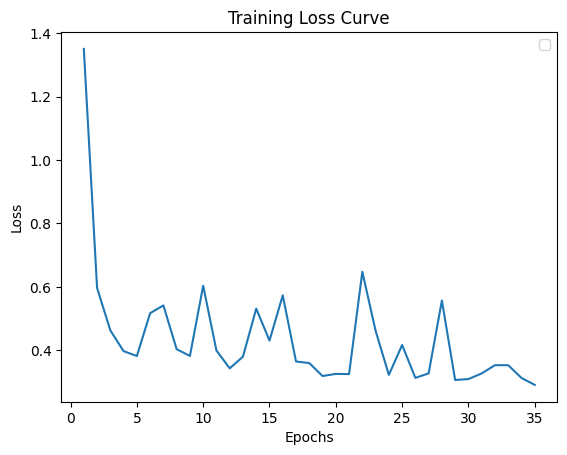

In [ ]:
plt.plot(steps, losses)
plt.title("Training Loss Curve")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
# augmented
model_unet_aug = UNet().to(DEVICE)
criterion_unet = nn.BCEWithLogitsLoss()
optimizer_unet_aug = optim.Adam(model_unet_aug.parameters(), lr=0.001)



model_segnet_aug = train_model(model_unet_aug, train_augmented_loader, val_loader, criterion_unet, optimizer_unet_aug, num_epochs=35, device=DEVICE)
trained_models_info.append((model_unet_aug, "train_augmented_dataset", criterion_unet, optimizer_unet_aug, 0.001, 10))



torch.save(model_unet_aug.state_dict(), "segmentation_model_unet_aug.pth")


100%|██████████| 15/15 [00:26<00:00,  1.73s/it]


Epoch 1/35, Loss: 0.559632686773936


100%|██████████| 58/58 [00:03<00:00, 16.56it/s]


Validation Loss: 0.7022566795349121


100%|██████████| 15/15 [00:29<00:00,  1.97s/it]


Epoch 2/35, Loss: 0.5114294826984406


100%|██████████| 58/58 [00:05<00:00, 11.36it/s]


Validation Loss: 0.5972922747505123


100%|██████████| 15/15 [00:35<00:00,  2.37s/it]


Epoch 3/35, Loss: 0.48952601154645287


100%|██████████| 58/58 [00:03<00:00, 15.78it/s]


Validation Loss: 1.1848940063139488


100%|██████████| 15/15 [01:19<00:00,  5.29s/it]


Epoch 4/35, Loss: 0.4786218543847402


100%|██████████| 58/58 [00:03<00:00, 17.05it/s]


Validation Loss: 1.8983607579921853


100%|██████████| 15/15 [00:18<00:00,  1.24s/it]


Epoch 5/35, Loss: 0.4635863443215688


100%|██████████| 58/58 [00:03<00:00, 17.55it/s]


Validation Loss: 0.4281883034212836


100%|██████████| 15/15 [00:18<00:00,  1.25s/it]


Epoch 6/35, Loss: 0.4486226737499237


100%|██████████| 58/58 [00:03<00:00, 17.58it/s]


Validation Loss: 0.6702448800206184


100%|██████████| 15/15 [00:18<00:00,  1.24s/it]


Epoch 7/35, Loss: 0.4480800668398539


100%|██████████| 58/58 [00:03<00:00, 17.71it/s]


Validation Loss: 0.48764555284689215


100%|██████████| 15/15 [00:20<00:00,  1.36s/it]


Epoch 8/35, Loss: 0.4641194760799408


100%|██████████| 58/58 [00:05<00:00, 10.81it/s]


Validation Loss: 0.6012490065447216


100%|██████████| 15/15 [00:24<00:00,  1.65s/it]


Epoch 9/35, Loss: 0.43619004686673485


100%|██████████| 58/58 [00:03<00:00, 15.09it/s]


Validation Loss: 0.48254391319792844


100%|██████████| 15/15 [00:22<00:00,  1.51s/it]


Epoch 10/35, Loss: 0.4359645863374074


100%|██████████| 58/58 [00:03<00:00, 15.43it/s]


Validation Loss: 0.5391029065539097


100%|██████████| 15/15 [00:23<00:00,  1.54s/it]


Epoch 11/35, Loss: 0.4532692551612854


100%|██████████| 58/58 [00:03<00:00, 15.43it/s]


Validation Loss: 0.6475428697364084


100%|██████████| 15/15 [01:50<00:00,  7.37s/it]


Epoch 12/35, Loss: 0.4408032536506653


100%|██████████| 58/58 [00:03<00:00, 14.89it/s]


Validation Loss: 0.4821364483956633


100%|██████████| 15/15 [00:26<00:00,  1.80s/it]


Epoch 13/35, Loss: 0.45647122263908385


100%|██████████| 58/58 [00:03<00:00, 15.53it/s]


Validation Loss: 0.7896930403236685


100%|██████████| 15/15 [00:24<00:00,  1.62s/it]


Epoch 14/35, Loss: 0.45273244579633076


100%|██████████| 58/58 [00:03<00:00, 15.67it/s]


Validation Loss: 0.47596211577283926


100%|██████████| 15/15 [00:22<00:00,  1.49s/it]


Epoch 15/35, Loss: 0.4392066756884257


100%|██████████| 58/58 [00:03<00:00, 16.04it/s]


Validation Loss: 0.4419681617412074


100%|██████████| 15/15 [00:21<00:00,  1.46s/it]


Epoch 16/35, Loss: 0.4338852981726328


100%|██████████| 58/58 [00:03<00:00, 16.54it/s]


Validation Loss: 0.5345228211633091


100%|██████████| 15/15 [00:20<00:00,  1.39s/it]


Epoch 17/35, Loss: 0.45054181615511574


100%|██████████| 58/58 [00:03<00:00, 16.32it/s]


Validation Loss: 0.472763912431125


100%|██████████| 15/15 [00:19<00:00,  1.31s/it]


Epoch 18/35, Loss: 0.4303074796994527


100%|██████████| 58/58 [00:03<00:00, 14.58it/s]


Validation Loss: 0.4157551221292594


100%|██████████| 15/15 [00:19<00:00,  1.32s/it]


Epoch 19/35, Loss: 0.4253572583198547


100%|██████████| 58/58 [00:03<00:00, 18.06it/s]


Validation Loss: 0.44838234062852533


100%|██████████| 15/15 [00:18<00:00,  1.22s/it]


Epoch 20/35, Loss: 0.4398300846417745


100%|██████████| 58/58 [00:03<00:00, 17.30it/s]


Validation Loss: 0.49129365101970474


100%|██████████| 15/15 [00:18<00:00,  1.20s/it]


Epoch 21/35, Loss: 0.44206223090489705


100%|██████████| 58/58 [00:03<00:00, 17.70it/s]


Validation Loss: 0.47939598457566623


100%|██████████| 15/15 [00:17<00:00,  1.20s/it]


Epoch 22/35, Loss: 0.4297609408696493


100%|██████████| 58/58 [00:03<00:00, 18.01it/s]


Validation Loss: 0.5071120534477562


100%|██████████| 15/15 [00:18<00:00,  1.20s/it]


Epoch 23/35, Loss: 0.4139892061551412


100%|██████████| 58/58 [00:03<00:00, 18.01it/s]


Validation Loss: 0.5337011408189247


100%|██████████| 15/15 [00:19<00:00,  1.30s/it]


Epoch 24/35, Loss: 0.4179350276788076


100%|██████████| 58/58 [00:03<00:00, 17.67it/s]


Validation Loss: 0.44408993782668277


100%|██████████| 15/15 [00:18<00:00,  1.25s/it]


Epoch 25/35, Loss: 0.4303213914235433


100%|██████████| 58/58 [00:03<00:00, 17.01it/s]


Validation Loss: 0.581227189636436


100%|██████████| 15/15 [00:18<00:00,  1.22s/it]


Epoch 26/35, Loss: 0.4304220716158549


100%|██████████| 58/58 [00:03<00:00, 17.51it/s]


Validation Loss: 0.45964741218706656


100%|██████████| 15/15 [00:18<00:00,  1.25s/it]


Epoch 27/35, Loss: 0.4399171392122904


100%|██████████| 58/58 [00:03<00:00, 17.56it/s]


Validation Loss: 0.7152648326651804


100%|██████████| 15/15 [00:19<00:00,  1.28s/it]


Epoch 28/35, Loss: 0.4219362636407216


100%|██████████| 58/58 [00:03<00:00, 17.40it/s]


Validation Loss: 0.4392765639670964


100%|██████████| 15/15 [00:18<00:00,  1.25s/it]


Epoch 29/35, Loss: 0.40695005655288696


100%|██████████| 58/58 [00:03<00:00, 17.42it/s]


Validation Loss: 0.427968284436341


100%|██████████| 15/15 [00:18<00:00,  1.23s/it]


Epoch 30/35, Loss: 0.4147268573443095


100%|██████████| 58/58 [00:03<00:00, 17.71it/s]


Validation Loss: 0.5475118237322775


100%|██████████| 15/15 [00:18<00:00,  1.23s/it]


Epoch 31/35, Loss: 0.4258823851744334


100%|██████████| 58/58 [00:03<00:00, 16.45it/s]


Validation Loss: 0.44719665060783254


100%|██████████| 15/15 [00:18<00:00,  1.21s/it]


Epoch 32/35, Loss: 0.39481050372123716


100%|██████████| 58/58 [00:03<00:00, 17.89it/s]


Validation Loss: 0.4425687792486158


100%|██████████| 15/15 [00:18<00:00,  1.22s/it]


Epoch 33/35, Loss: 0.3977596163749695


100%|██████████| 58/58 [00:03<00:00, 17.80it/s]


Validation Loss: 0.3867672922025467


100%|██████████| 15/15 [00:19<00:00,  1.30s/it]


Epoch 34/35, Loss: 0.3972383618354797


100%|██████████| 58/58 [00:03<00:00, 17.27it/s]


Validation Loss: 0.5208410040057939


100%|██████████| 15/15 [00:18<00:00,  1.27s/it]


Epoch 35/35, Loss: 0.41787081559499106


100%|██████████| 58/58 [00:03<00:00, 17.20it/s]


Validation Loss: 0.3745787156553104


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


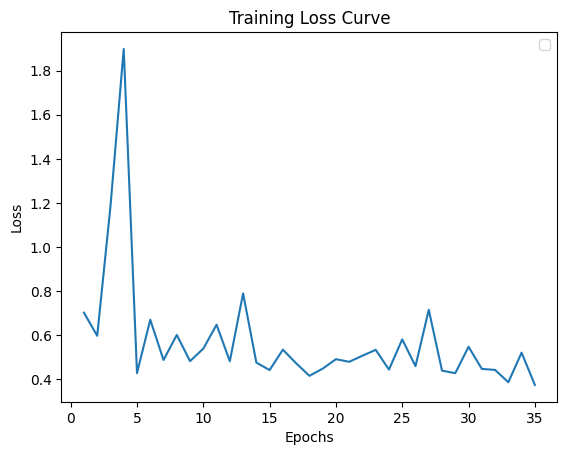

In [ ]:
plt.plot(steps, losses)
plt.title("Training Loss Curve")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [ ]:
def dice_coef(groundtruth_mask, pred_mask):
    intersect = np.sum(pred_mask*groundtruth_mask)
    total_sum = np.sum(pred_mask) + np.sum(groundtruth_mask)
    dice = np.mean(2*intersect/total_sum)
    return dice

In [ ]:
def dice_score_calculation(model, val_dataset):
    model.eval()
    dice_scores = []
    with torch.no_grad():
        for sample in val_dataset:
            image = sample["image"].unsqueeze(0).to(DEVICE)
            mask = sample["mask"].numpy().squeeze()
            orig_size = sample["orig_size"]

            y = model(image).sigmoid().cpu().numpy().squeeze()

            binary_mask = (y > 0.5).astype(np.float32)

            # Resize the binary mask and ground truth mask to the original size
            binary_mask_resized = cv2.resize(binary_mask, (orig_size[1], orig_size[0]), interpolation=cv2.INTER_NEAREST)
            mask_resized = cv2.resize(mask, (orig_size[1], orig_size[0]), interpolation=cv2.INTER_NEAREST)

            dice = dice_coef(mask_resized, binary_mask_resized)
            dice_scores.append(dice)

    return np.mean(dice_scores)



In [ ]:

dice_score_calculation(model_unet, validation_dataset)


0.8150344827586207

In [ ]:
dice_score_calculation(model_unet_aug, validation_dataset)

0.7483965517241379

In [ ]:
unet_model = UNet().to(DEVICE)
unet_model.load_state_dict(torch.load('segmentation_model_unet.pth'))

unet_model_aug = UNet().to(DEVICE)
unet_model_aug.load_state_dict(torch.load('segmentation_model_unet_aug.pth'))

C:\Users\Admin\AppData\Local\Temp\ipykernel_7420\1906205383.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  unet_model.load_state_dict(torch.load('segmentation_model_une

<All keys matched successfully>

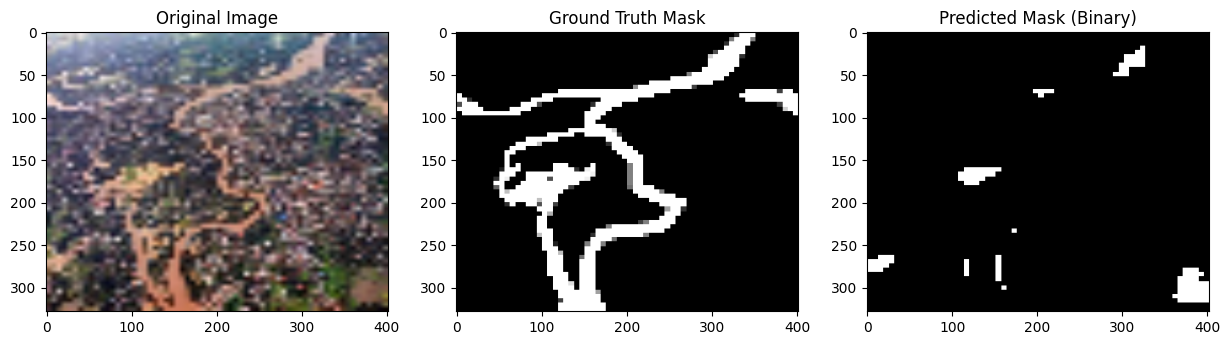

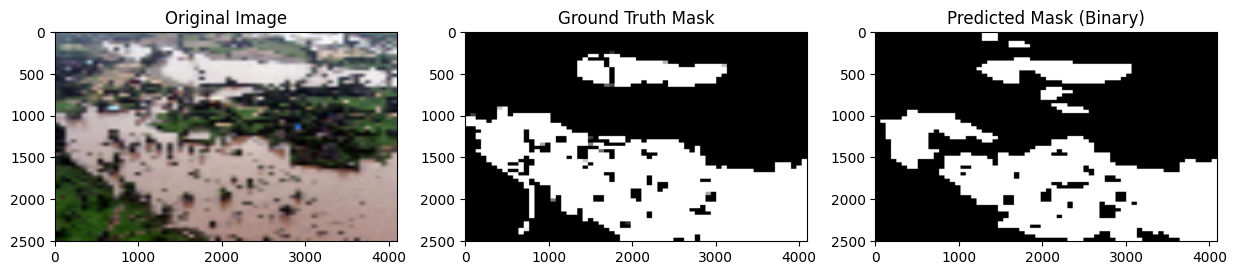

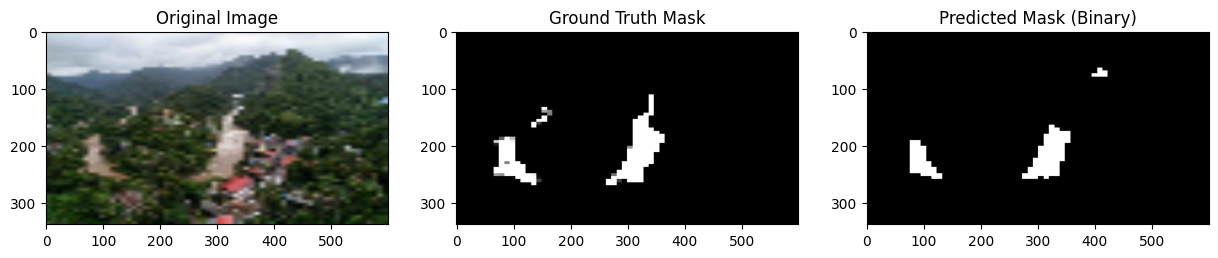

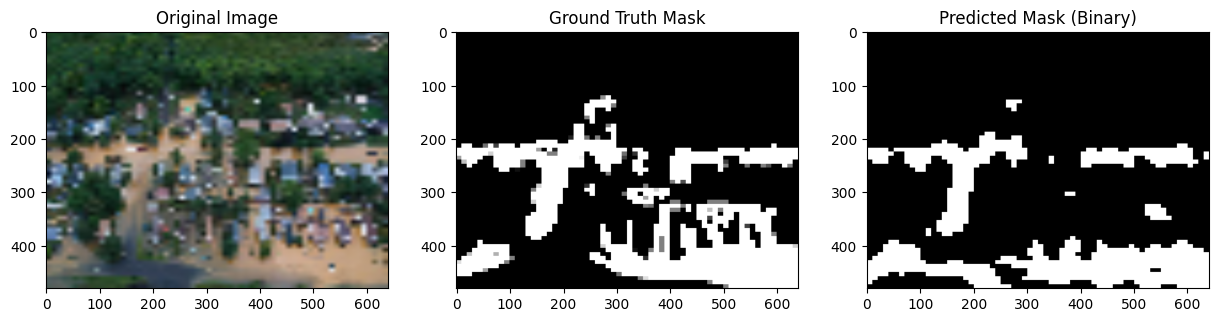

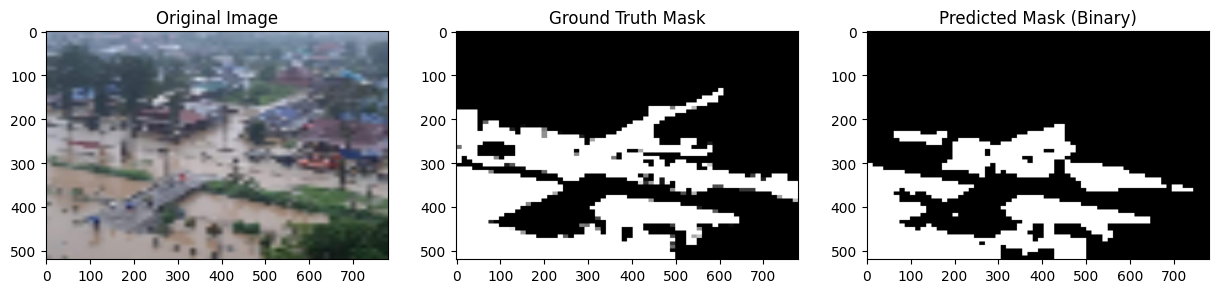

In [ ]:
visualize_predictions(validation_dataset, unet_model, num_samples=5)

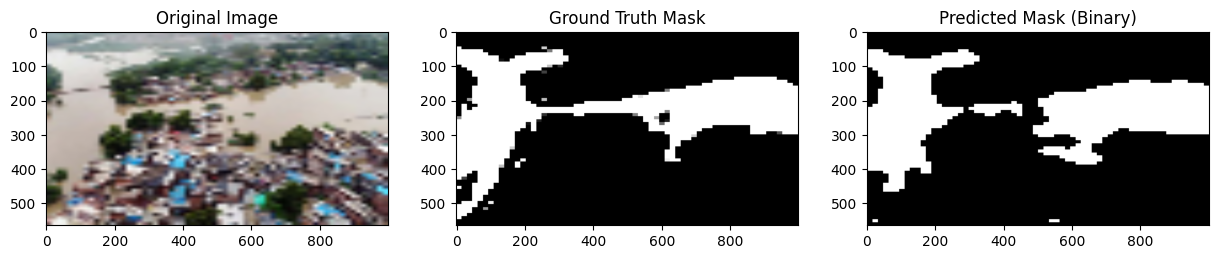

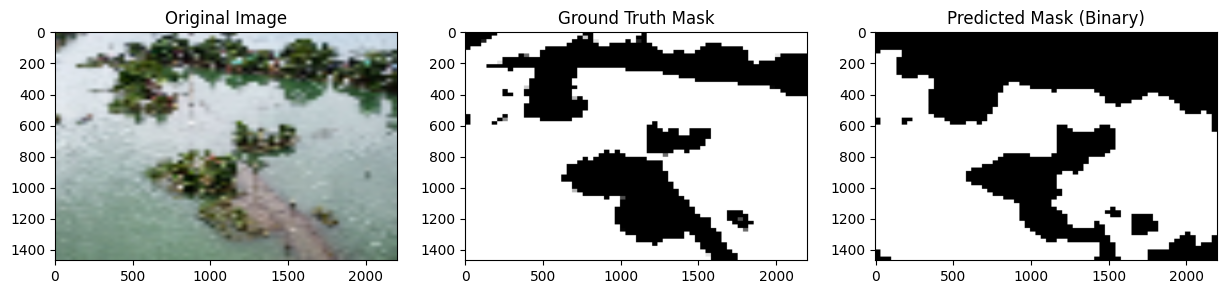

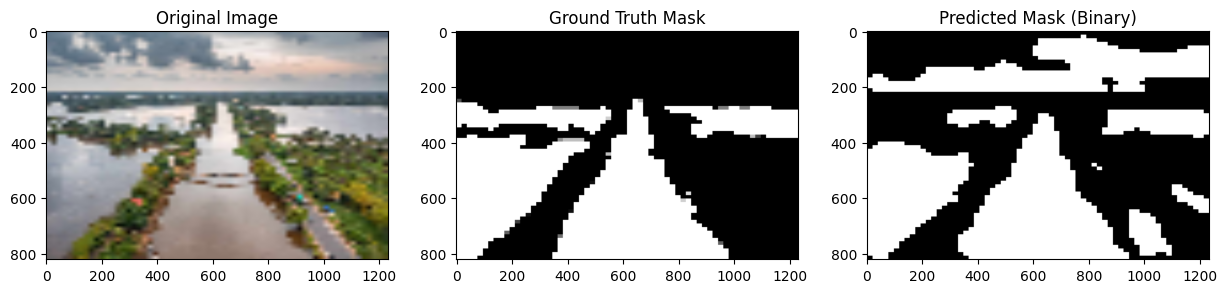

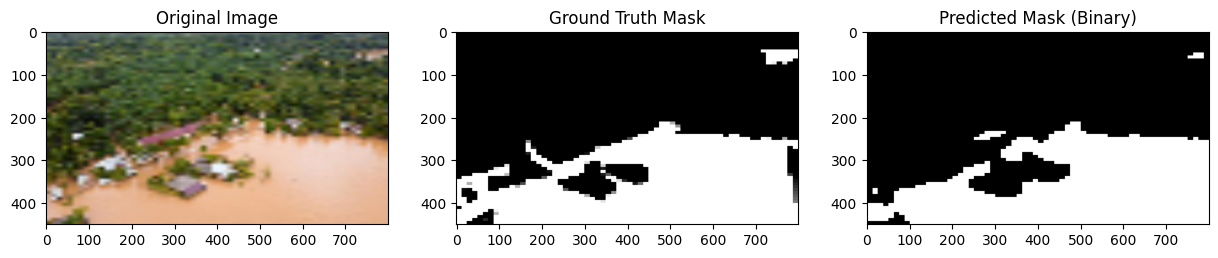

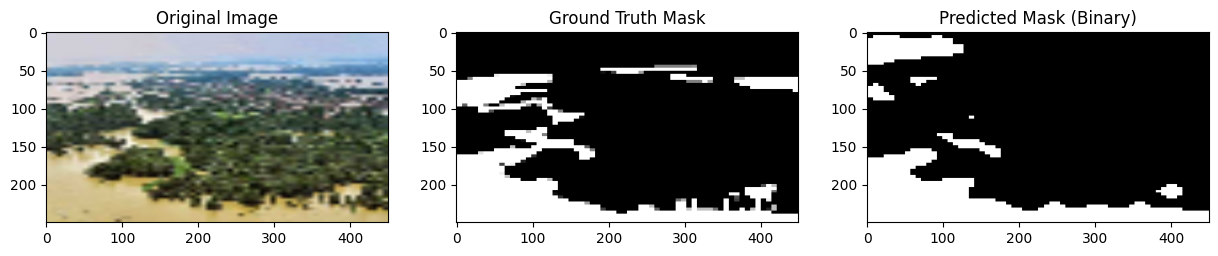

In [ ]:
visualize_predictions(validation_dataset, unet_model_aug, num_samples=5)